**Locality-sensitive hashing**: Consider a locality sensitive hashing function $h$ associated with distance function $d$. Assume that $h$ and $d$ are associated with the following relationship:

$$\text{Pr}(h(x)\neq h(y)) = d(x,y)$$

for every pair of points $x,y$.

Show that if the above equation is correct, then $d$ is a metric.


### Proof 1 :

#### 1. Non-negativity : d(x,y) >= 0

Since d is calculated as the probability of the hashes of x and y being equal, d always lies between 0 and 1. <br>
So, d(x,y) >= 0

#### 2. Isolation : d(x,y) = 0 <=> x = y

#### a) x = y => d(x,y) = 0

When x = y, <br>
d(x,x) = Pr(h(x) != h(x)) = 0 <br>

#### b) d(x,y) = 0 => x = y

d(x,y) = 0 <br>
Pr(h(x) != h(y)) = 0 <br>
The probability that the hashes are not equal is zero implies that they are the same hashes.
=> h(x) = h(y)
x = y

#### 3. Symmetry : d(x,y) = d(y,x)

d(x,y) = Pr(h(x) != h(y)) <br>
= Pr(h(y) != h(x)) <br>
= d(y,x) <br>

#### 4. Triangle inequality : d(x,y) <= d(x,z) + d(z,y)

d(x,y) = Pr(h(x) != h(y)) <br>
= Pr(h(x) != h(y), h(x) = h(z)) + Pr(h(x) !=h(y), h(x) != h(z)) <br>
<= Pr(h(y) != h(z)) + Pr(h(x) != h(z)) <br>
<= d(y,z) + d(x,z) <br>

### Since it satisfies all 4 properties, it is a distance metric. 

**Dimensionality Reduction**: There are multiple techniques for performing dimensionality reduction. In this problem, we will use *Johnson-Lindenstrauss* (lemma) and *SVD*.

### 2.1 Loading Data

We have prepared 10 images from the imagenet2012 dataset. We have chosen 5 images that belong to a class (class 0) and 5 images that belong to another class (class 1). The images are contained in a zip file that has been posted on piazza. Download this zip file.

Write code that loads each image (using numpy) and unrolls the image into one long vector. Each image vector should then be stacked to form a matrix with 10 rows and 256*256*3 columns. You will also need to cast each vector to be floating point instead of unsigned integers.

In [72]:
import numpy as np
import glob

matrix = np.empty((0,196608))

for file in glob.glob('./hw2_data_10_imgs/class_[01]/*.np[yz]'):
    matrix = np.vstack([matrix,np.load(file).reshape(-1).astype(np.float)])

### 2.2 SVD 

Please use SVD to reduce the dimensionality of the images you loaded from part 2.1 to 2 dimensions. Also plot the dataset using feature 1 as the x axis and feature 2 as the y axis. Color code each point based on whether that point belongs to class 0 or class 1 (blue points for class 0 and red points for class 1). In your opinion, can we distinguish between the two classes in the 2-dimensional data?

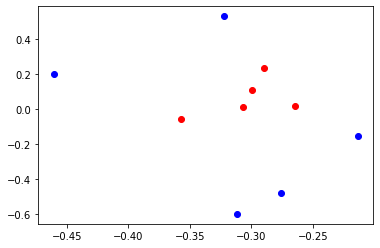

In [74]:
import matplotlib.pyplot as plt

u,s,vt=np.linalg.svd(matrix,full_matrices=False)

plt.scatter(u[:5,0], u[:5,1], color = 'red')
plt.scatter(u[5:,0], u[5:,1], color = 'blue')
plt.show()

No, we cannot distinguish between the two classes in the 2-dimensional data as there is no clear linear boundary.

### 2.3 Johnson Lindenstrauss:

Reminder, the Johnson-Lindenstrauss Lemma is as follows:

Given $\epsilon > 0$ and $n\in \mathbb{Z}^{>0}$, let $k \in \mathbb{Z}^{>0}$ such that $k \ge k_0 \in O(\epsilon^{-2}\log{n})$. For every set $P$ of $n$ points in $\mathbb{R}^{d}$ there exists $f: \mathbb{R}^{d} \rightarrow \mathbb{R}^{k}$ such that for all $\{u,v\}\in P$
$$(1-\epsilon)||u-v||_2^2 \le ||f(u)-f(v)||_2^2 \le (1+\epsilon)||u-v||_2^2$$

Basically, JL tells us that we can map any point cloud into a smaller dimensionality while (roughly) preserving the local geometry of the point cloud.

We would like to take this a step further. Let us use a slightly different version of JL which is more straighforward to implement (from this paper http://people.ee.duke.edu/~lcarin/p93.pdf):

Given $\epsilon, \beta > 0$ let $k_0 = \frac{4+2\beta}{\epsilon^2/2 - \epsilon^3/3}\log{n}$. For every integer $k\ge k_0$, let $R$ be a $d\times k$ random matrix with $R(i,j) = r_{ij}$ where each $r_{ij}$ are independent random variables with pmf:

$r_{ij} = \sqrt{3}\times\begin{cases}
+1 & \text{w/ prob } 1/6\\
0  & \text{w/ prob } 2/3\\
-1 & \text{w/ prob } 1/6
\end{cases}$

Let $f: \mathbb{R}^{d} \rightarrow \mathbb{R}^{k} = \frac{1}{\sqrt{k}}R$

With probability at least $1-n^{-\beta}$, for all $u,v\in P$
$$(1-\epsilon)||u-v||_2^2 \le ||\frac{1}{\sqrt{k}}Ru-\frac{1}{\sqrt{k}}Rv||_2^2 \le (1+\epsilon)||u-v||_2^2$$

#### 2.3.1 JL Implementation 

Write code to implement the *sparse* JL version mentioned above. Your code should be a python function which should take as arguments the point cloud $A$, and parameters $\epsilon$, $\beta$, and $k$. Your function should produce the points in the new dimensional space.

In [126]:
def randomElement(i):
    return ((3 ** (1/2)) * np.random.choice([1, 0, -1], p=[1/6, 2/3, 1/6]))

def monteCarlo_JL(A, epsilon, beta, k):
    
    R = np.vectorize(randomElement)(np.empty((k, A.shape[1])))
    R *= (1.0/(k ** (1/2)))
    pointCloud = np.matmul(A, R.transpose())
    
    return pointCloud

#### 2.3.2 Guaranteeing JL 

Note that JL is probabilistic, in other words when we sample $R$, we might not succeed. This is called a *Monte-Carlo* algorithm (may not succeed but has polynomial runtime). We would like to convert this into a *Las-Vegas* algorithm (always succeeds but may not have bounded runtime however has polynomial expected runtime).

Write code to convert JL into a Las-Vegas algorithm by repeating the JL transform until it succeeds. Your algorithm should produce the data in the new dimsionality as well as the number of iterations your algorithm took to succeed. 

In [127]:
from scipy.spatial.distance import cdist

def checkBounds(distPC, distA, epsilon):
    if(((1 - epsilon) * distA > distPC).any() or (distPC > (1 + epsilon) * distA).any()):
        return False
    return True

def lasVegas_JL(A, epsilon, beta, k):
    
    flag = False
    iteration = 0
    while(flag == False):
        iteration += 1
        pointCloud = monteCarlo_JL(A, epsilon, beta, k)
        distPC = cdist(pointCloud, pointCloud, 'euclid')
        distA = cdist(A, A, 'euclid')
        flag = checkBounds(distPC, distA, epsilon)
        
    return iteration, pointCloud 

#### 2.3.4 JL Experiments 

Note that we *cannot* project the images into 2 dimensions using JL while approximately preserving the geometry of the points (why not?). Choose $\epsilon,\beta$ so that we map the images into 32 dimensions (which is still much smaller than the original dimensionality!). Run the algorithm 100 times and record the number of iterations after each trial and compute the empirical average of your samples. Does the empirical average match the expected number of iterations?

We cannot project the images into 2 dimensions using JL while approximately preserving the geometry of the points because, the value of k must be such that $k \ge k_0 \in O(\epsilon^{-2}\log{n})$ and $k=2 << k_0$

In [129]:
iterations = []
for i in range(100):
    iteration, pointCloud = lasVegas_JL(matrix, 0.8, 0.5, 32)
    iterations.append(iteration)

print("Emperical Average = ", sum(iterations)/len(iterations))

Emperical Average =  1.0


#### 2.3.5 Comparing JL to SVD 

Even though we cannot preserve the geometry while mapping to 2 dimensions, lets do it anyways. Project the images into two dimensions using your Monte-Carlo JL function and plot the resulting data using the same scheme as when we plotted the results from SVD. Can we distinguish between the two classes?

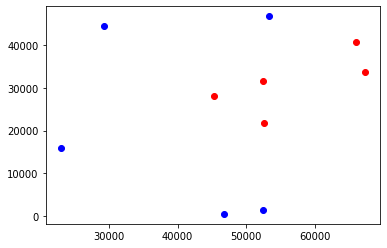

In [80]:
pointCloud = monteCarlo_JL(matrix, 0.8, 0.5, 2)
plt.scatter(pointCloud[:5,0], pointCloud[:5,1], color = 'red')
plt.scatter(pointCloud[5:,0], pointCloud[5:,1], color = 'blue')
plt.show()

No, we still can't distinguish between the two classes since there's no proper linear boundary.